---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---



# Saving and Loading {#sec-spotpython-saving-and-loading}

This tutorial shows how to save and load objects in `spotPython`.
It is split into the following parts:
- @sec-spotpython-saving-and-loading shows how to save and load objects in `spotPython`, if `spotPython` is used as an optimizer.
- @sec-spotpython-as-a-hyperparameter-tuner-37 shows how to save and load hyperparameter tuning experiments.
- @sec-saving-and-loading-pytorch-lightning-models-37 shows how to save and load `PyTorch Lightning` models.
- @sec-converting-a-lightning-model-to-a-plain-torch-model-37 shows how to convert a `PyTorch Lightning` model to a plain `PyTorch` model.

## spotPython: Saving and Loading Optimization Experiments {#sec-spotpython-saving-and-loading}

In this section, we will show how results from `spotPython` can be saved and reloaded.
Here, `spotPython` can be used as an optimizer. 

### spotPython as an Optimizer

If `spotPython` is used as an optimizer, no dictionary of hyperparameters has be specified. The `fun_control` dictionary is sufficient. 


In [1]:
#| label: code-optimization-experiment-37
import os
import pprint
from spotPython.utils.file import load_experiment
from spotPython.utils.file import get_experiment_filename
import numpy as np
from math import inf
from spotPython.spot import spot
from spotPython.utils.init import (
    fun_control_init,
    design_control_init,
    surrogate_control_init,
    optimizer_control_init)
from spotPython.fun.objectivefunctions import analytical
fun = analytical().fun_branin
fun_control = fun_control_init(
            PREFIX="branin",
            SUMMARY_WRITER=False,
            lower = np.array([0, 0]),
            upper = np.array([10, 10]),
            fun_evals=8,
            fun_repeats=1,
            max_time=inf,
            noise=False,
            tolerance_x=0,
            ocba_delta=0,
            var_type=["num", "num"],
            infill_criterion="ei",
            n_points=1,
            seed=123,
            log_level=20,
            show_models=False,
            show_progress=True)
design_control = design_control_init(
            init_size=5,
            repeats=1)
surrogate_control = surrogate_control_init(
            model_fun_evals=10000,
            min_theta=-3,
            max_theta=3,
            n_theta=2,
            theta_init_zero=True,
            n_p=1,
            optim_p=False,
            var_type=["num", "num"],
            seed=124)
optimizer_control = optimizer_control_init(
            max_iter=1000,
            seed=125)
spot_tuner = spot.Spot(fun=fun,
            fun_control=fun_control,
            design_control=design_control,
            surrogate_control=surrogate_control,
            optimizer_control=optimizer_control)
spot_tuner.run()
PREFIX = fun_control["PREFIX"]
filename = get_experiment_filename(PREFIX)
spot_tuner.save_experiment(filename=filename)
print(f"filename: {filename}")

Seed set to 123


Seed set to 123


spotPython tuning: 4.7932399644479124 [########--] 75.00% 


spotPython tuning: 2.0379795645847087 [#########-] 87.50% 


spotPython tuning: 1.986328241945829 [##########] 100.00% Done...



filename: spot_branin_experiment.pickle


In [2]:
#| label: code-reload-optimization-experiment-37
(spot_tuner_1, fun_control_1, design_control_1,
    surrogate_control_1, optimizer_control_1) = load_experiment(filename)

The progress of the original experiment is shown in @fig-plot-progress-37a and the reloaded experiment in @fig-plot-progress-37b.


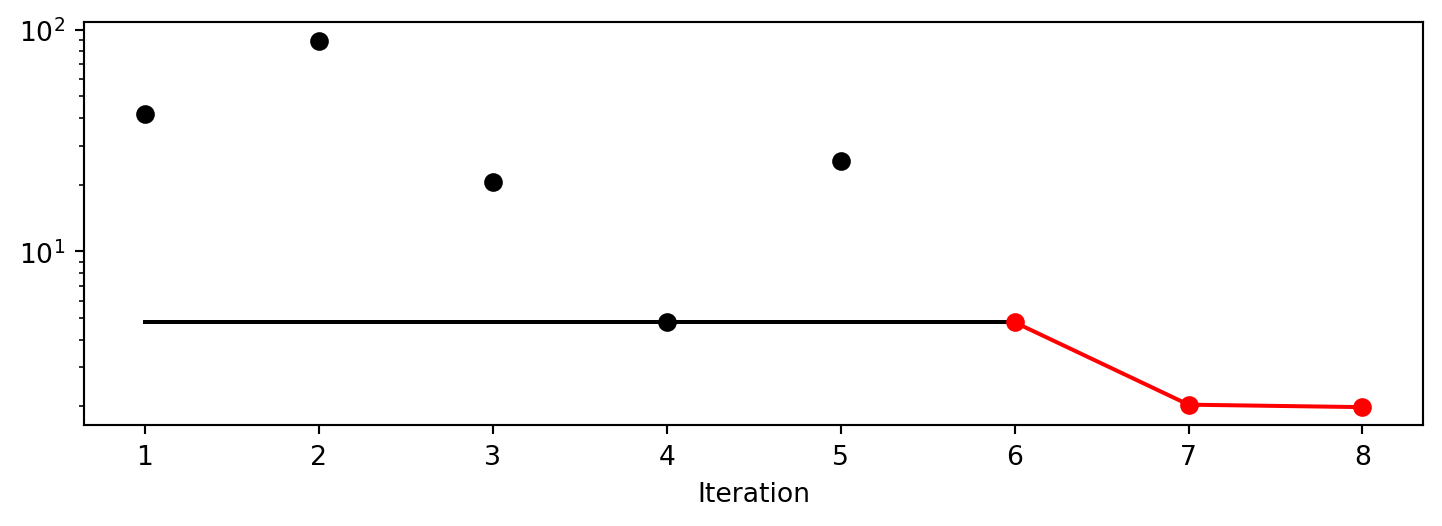

In [3]:
#| label: fig-plot-progress-37a
#| fig-cap: Progress of the original experiment
spot_tuner.plot_progress(log_y=True)

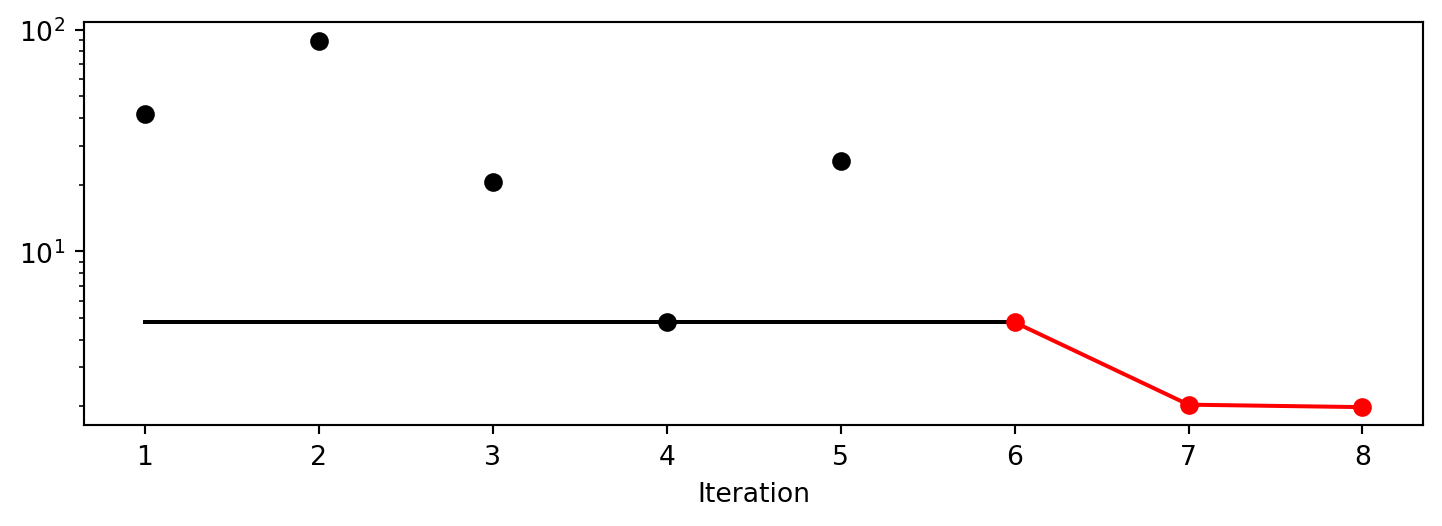

In [4]:
#| label: fig-plot-progress-37b
#| fig-cap: Progress of the reloaded experiment
spot_tuner_1.plot_progress(log_y=True)

The results from the original experiment are shown in @tbl-results-37a and the reloaded experiment in @tbl-results-37b.


In [5]:
#| label: tbl-results-37a
spot_tuner.print_results()

min y: 1.986328241945829
x0: 10.0
x1: 3.2107728198306598


[['x0', 10.0], ['x1', 3.2107728198306598]]

In [6]:
#| label: tbl-results-37b
spot_tuner_1.print_results()

min y: 1.986328241945829
x0: 10.0
x1: 3.2107728198306598


[['x0', 10.0], ['x1', 3.2107728198306598]]

#### Getting the Tuned Hyperparameters

The tuned hyperparameters can be obtained as a dictionary with the following code.


In [7]:
#| label: code-get-tuned-optimization-37
from spotPython.hyperparameters.values import get_tuned_hyperparameters
get_tuned_hyperparameters(spot_tuner=spot_tuner)

{'x0': 10.0, 'x1': 3.2107728198306598}

::: {.callout-note}
### Summary: Saving and Loading Optimization Experiments
* If `spotPython` is used as an optimizer (without an hyperparameter dictionary), experiments can be saved and reloaded with the `save_experiment` and `load_experiment` functions.
* The tuned hyperparameters can be obtained with the `get_tuned_hyperparameters` function.
:::



## spotPython as a Hyperparameter Tuner {#sec-spotpython-as-a-hyperparameter-tuner-37}

If `spotPython` is used as a hyperparameter tuner, in addition to the `fun_control` dictionary a `core_model` dictionary have to be specified.
This will be explained in @sec-adding-a-core-model-37.

Furthermore, a data set has to be selected and added to the `fun_control` dictionary.
Here, we will use the `Diabetes` data set.


### The Diabetes Data Set

The hyperparameter tuning of a `PyTorch Lightning` network on the `Diabetes` data set is used as an example. The `Diabetes` data set is a PyTorch Dataset for regression, which originates from the `scikit-learn` package, see [https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes).

 Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients,  as well as the response of interest, a quantitative measure of disease progression one year after baseline.
The `Diabetes` data set is described in @tbl-diabetes-31.

| Description | Value |
| --- | --- |
| Samples total | 442 |
| Dimensionality | 10 |
| Features | real, -.2 < x < .2 |
| Targets | integer 25 - 346 |
: The Diabetes data set {#tbl-diabetes-31}


In [8]:
#| label: code-hyperparameter-tuning-37
from spotPython.utils.device import getDevice
from math import inf
from spotPython.utils.init import fun_control_init
import numpy as np
from spotPython.hyperparameters.values import set_control_key_value
from spotPython.data.diabetes import Diabetes

MAX_TIME = inf
FUN_EVALS = 8
INIT_SIZE = 5
WORKERS = 0
PREFIX="037"
DEVICE = getDevice()
DEVICES = 1
TEST_SIZE = 0.4
TORCH_METRIC = "mean_squared_error"
dataset = Diabetes()

fun_control = fun_control_init(
    _L_in=10,
    _L_out=1,
    _torchmetric=TORCH_METRIC,
    PREFIX=PREFIX,
    TENSORBOARD_CLEAN=True,
    data_set=dataset,
    device=DEVICE,
    enable_progress_bar=False,
    fun_evals=FUN_EVALS,
    log_level=10,
    max_time=MAX_TIME,
    num_workers=WORKERS,
    show_progress=True,
    test_size=TEST_SIZE,
    tolerance_x=np.sqrt(np.spacing(1)),
    )

Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_07_05_21_35_23
Created spot_tensorboard_path: runs/spot_logs/037_p040025_2024-07-05_21-35-23 for SummaryWriter()


### Adding a `core_model` to the `fun_control` Dictionary {#sec-adding-a-core-model-37}

`spotPython` includes the `NetLightRegression` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/NetLightRegression.py) for configurable neural networks. 
The class is imported here. It inherits from the class `Lightning.LightningModule`, which is the base class for all models in `Lightning`. `Lightning.LightningModule` is a subclass of `torch.nn.Module` and provides additional functionality for the training and testing of neural networks. The class `Lightning.LightningModule` is described in the [Lightning documentation](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).


The hyperparameters of the model are specified in the `core_model_hyper_dict` dictionary [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperdict/light_hyper_dict.json).

The `core_model` dictionary contains the hyperparameters of the model to be tuned. These hyperparameters can be specified and modified with as shown in the following code.


In [9]:
#| label: code-add-core-model-to-fun-control-37
from spotPython.light.regression.netlightregression import NetLightRegression
from spotPython.hyperdict.light_hyper_dict import LightHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control
add_core_model_to_fun_control(fun_control=fun_control,
                              core_model=NetLightRegression,
                              hyper_dict=LightHyperDict)
from spotPython.hyperparameters.values import set_control_hyperparameter_value

set_control_hyperparameter_value(fun_control, "epochs", [4, 5])
set_control_hyperparameter_value(fun_control, "batch_size", [4, 5])
set_control_hyperparameter_value(fun_control, "optimizer", [
                "Adam",
                "RAdam",
            ])
set_control_hyperparameter_value(fun_control, "dropout_prob", [0.01, 0.1])
set_control_hyperparameter_value(fun_control, "lr_mult", [0.05, 1.0])
set_control_hyperparameter_value(fun_control, "patience", [2, 3])
set_control_hyperparameter_value(fun_control, "act_fn",[
                "ReLU",
                "LeakyReLU"
            ] )

Setting hyperparameter epochs to value [4, 5].
Variable type is int.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter batch_size to value [4, 5].
Variable type is int.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter optimizer to value ['Adam', 'RAdam'].
Variable type is factor.
Core type is str.
Calling modify_hyper_parameter_levels().
Setting hyperparameter dropout_prob to value [0.01, 0.1].
Variable type is float.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter lr_mult to value [0.05, 1.0].
Variable type is float.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter patience to value [2, 3].
Variable type is int.
Core type is None.
Calling modify_hyper_parameter_bounds().
Setting hyperparameter act_fn to value ['ReLU', 'LeakyReLU'].
Variable type is factor.
Core type is instance().
Calling modify_hyper_parameter_levels().


In [10]:
import pprint as pp
from spotPython.hyperparameters.values import set_factor_hyperparameter_values
set_factor_hyperparameter_values(fun_control, "initialization", ["Default"])
pp.pprint(fun_control)

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'PREFIX': '037',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': 10,
 '_L_out': 1,
 '_torchmetric': 'mean_squared_error',
 'accelerator': 'auto',
 'converters': None,
 'core_model': <class 'spotPython.light.regression.netlightregression.NetLightRegression'>,
 'core_model_hyper_dict': {'act_fn': {'class_name': 'spotPython.torch.activation',
                                      'core_model_parameter_type': 'instance()',
                                      'default': 'ReLU',
                                      'levels': ['ReLU', 'LeakyReLU'],
                                      'lower': 0,
                                      'transform': 'None',
                                      'type': 'factor',
                                      'upper': 1},
                           'batch_size': {'default': 4,
                                          'lower': 4,
                                 

### `design_control`,  `surrogate_control` Dictionaries and the Objective Function {#sec-specifying-design-surrogate-control-dictionaries-37}

After specifying the `design_control` and `surrogate_control` dictionaries, the objective function `fun` from the class `HyperLight` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/fun/hyperlight.py) is selected. It implements an interface from `PyTorch`'s training, validation, and testing methods to `spotPython`.

Then, the hyperparameter tuning can be started.


In [11]:
#| label: code-start-hyperparameter-tuning-37
from spotPython.utils.init import design_control_init, surrogate_control_init
design_control = design_control_init(init_size=INIT_SIZE)

surrogate_control = surrogate_control_init(noise=True,
                                            n_theta=2)
from spotPython.fun.hyperlight import HyperLight
fun = HyperLight(log_level=10).fun
from spotPython.spot import spot
spot_tuner = spot.Spot(fun=fun,
                       fun_control=fun_control,
                       design_control=design_control,
                       surrogate_control=surrogate_control)
spot_tuner.run()

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 4.7 K  | [16, 10] | [16, 1]  
-------------------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      23630.99609375       │
│         val_loss          │      23630.99609375       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 1.4 K  | [32, 10] | [32, 1]  
-------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


train_model result: {'val_loss': 23630.99609375, 'hp_metric': 23630.99609375}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      23312.27734375       │
│         val_loss          │      23312.27734375       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 16.5 K | [16, 10] | [16, 1]  
-------------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


train_model result: {'val_loss': 23312.27734375, 'hp_metric': 23312.27734375}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │       19552.1796875       │
│         val_loss          │       19552.1796875       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 497    | [32, 10] | [32, 1]  
-------------------------------------------------------------
497       Trainable params
0         Non-trainable params
497       Total params
0.002     Total estimated model params size (MB)


train_model result: {'val_loss': 19552.1796875, 'hp_metric': 19552.1796875}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=16` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │       23842.2265625       │
│         val_loss          │       23842.2265625       │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 1.4 K  | [16, 10] | [16, 1]  
-------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


train_model result: {'val_loss': 23842.2265625, 'hp_metric': 23842.2265625}
LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=16` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      23955.794921875      │
│         val_loss          │      23955.794921875      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 23955.794921875, 'hp_metric': 23955.794921875}


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 16.5 K | [16, 10] | [16, 1]  
-------------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      19014.068359375      │
│         val_loss          │      19014.068359375      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 19014.068359375, 'hp_metric': 19014.068359375}


spotPython tuning: 19014.068359375 [########--] 75.00% 


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 16.5 K | [16, 10] | [16, 1]  
-------------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      19208.46484375       │
│         val_loss          │      19208.46484375       │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 19208.46484375, 'hp_metric': 19208.46484375}


spotPython tuning: 19014.068359375 [#########-] 87.50% 


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 16.5 K | [16, 10] | [16, 1]  
-------------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


`Trainer.fit` stopped: `max_epochs=32` reached.


LightDataModule.setup(): stage: TrainerFn.VALIDATING
LightDataModule.val_dataloader(). Val. set size: 106


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      19290.615234375      │
│         val_loss          │      19290.615234375      │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 19290.615234375, 'hp_metric': 19290.615234375}


spotPython tuning: 19014.068359375 [##########] 100.00% Done...



The tuned hyperparameters can be obtained as a dictionary with the following code.


In [12]:
#| label: code-get-tuned-hyperparameters-37
from spotPython.hyperparameters.values import get_tuned_hyperparameters
get_tuned_hyperparameters(spot_tuner)

{'l1': 7.0,
 'epochs': 5.0,
 'batch_size': 4.0,
 'act_fn': 0.0,
 'optimizer': 1.0,
 'dropout_prob': 0.09699240513877071,
 'lr_mult': 0.9054114496467818,
 'patience': 3.0,
 'initialization': 0.0}

Here , the numerical levels of the hyperparameters are used as keys in the dictionary.
If the `fun_control` dictionary is used, the names of the hyperparameters are used as keys in the dictionary. 


In [13]:
#| label: code-get-tuned-hyperparameters-fun-ctrl37
get_tuned_hyperparameters(spot_tuner, fun_control)

{'l1': 7.0,
 'epochs': 5.0,
 'batch_size': 4.0,
 'act_fn': 'ReLU',
 'optimizer': 'RAdam',
 'dropout_prob': 0.09699240513877071,
 'lr_mult': 0.9054114496467818,
 'patience': 3.0,
 'initialization': 'Default'}

In [14]:
#| label: code-save-experiment-37
PREFIX = fun_control["PREFIX"]
filename = get_experiment_filename(PREFIX)
spot_tuner.save_experiment(filename=filename)
print(f"filename: {filename}")

filename: spot_037_experiment.pickle


The results from the experiment are stored in the pickle file `{python} filename`.
The experiment can be reloaded with the following code.


In [15]:
#| label: code-reload-hyper-experiment-37
(spot_tuner_1, fun_control_1, design_control_1,
    surrogate_control_1, optimizer_control_1) = load_experiment(filename)

Plot the progress of the original experiment are identical to the reloaded experiment.


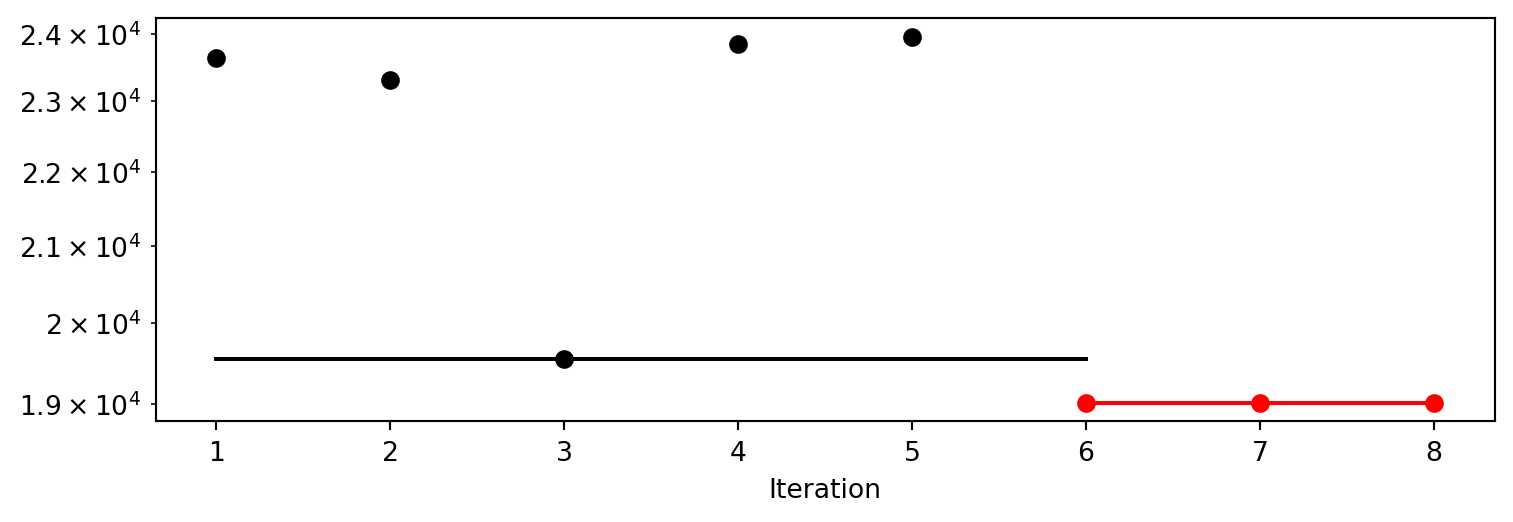

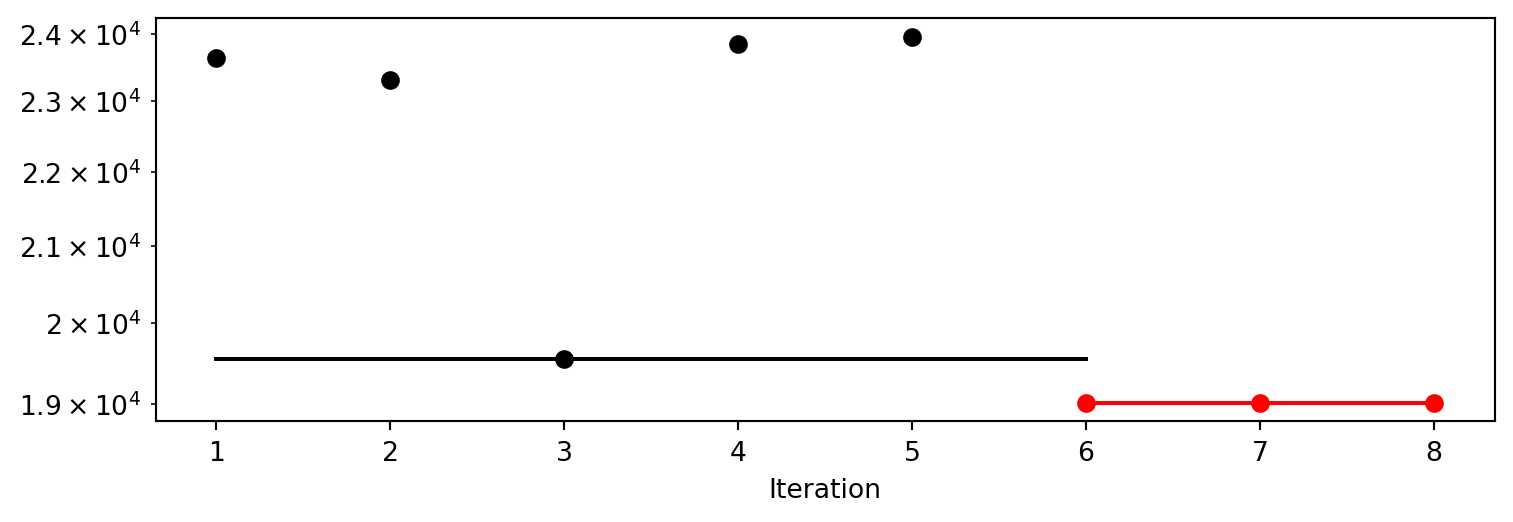

In [16]:
spot_tuner.plot_progress(log_y=True)
spot_tuner_1.plot_progress(log_y=True)

Finally, the tuned hyperparameters can be obtained as a dictionary from the reloaded experiment with the following code.


In [17]:
get_tuned_hyperparameters(spot_tuner_1, fun_control_1)

{'l1': 7.0,
 'epochs': 5.0,
 'batch_size': 4.0,
 'act_fn': 'ReLU',
 'optimizer': 'RAdam',
 'dropout_prob': 0.09699240513877071,
 'lr_mult': 0.9054114496467818,
 'patience': 3.0,
 'initialization': 'Default'}

::: {.callout-note}
### Summary: Saving and Loading Hyperparameter-Tuning Experiments
* If `spotPython` is used as an hyperparameter tuner (with an hyperparameter dictionary), experiments can be saved and reloaded with the `save_experiment` and `load_experiment` functions.
* The tuned hyperparameters can be obtained with the `get_tuned_hyperparameters` function.
:::


## Saving and Loading PyTorch Lightning Models {#sec-saving-and-loading-pytorch-lightning-models-37}

@sec-spotpython-saving-and-loading  and @sec-spotpython-as-a-hyperparameter-tuner-37 explained how to save and load optimization and hyperparameter tuning experiments and how to get the tuned hyperparameters as a dictionary.
This section shows how to save and load `PyTorch Lightning` models.


### Get the Tuned Architecture {#sec-get-spot-results-31}

In contrast to the function `get_tuned_hyperparameters`, the function `get_tuned_architecture` returns the tuned architecture of the model as a dictionary. Here, the transformations are already applied to the numerical levels of the hyperparameters and the encoding (and types) are the original types of the hyperparameters used by the model. The `config` dictionary can be passed to the model without any modifications.


In [18]:
from spotPython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
pprint.pprint(config)

{'act_fn': ReLU(),
 'batch_size': 16,
 'dropout_prob': 0.09699240513877071,
 'epochs': 32,
 'initialization': 'Default',
 'l1': 128,
 'lr_mult': 0.9054114496467818,
 'optimizer': 'RAdam',
 'patience': 8}


After getting the tuned architecture, the model can be created and tested with the following code.


In [19]:
from spotPython.light.testmodel import test_model
test_model(config, fun_control)

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs



  | Name   | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------
0 | layers | Sequential | 16.5 K | [16, 10] | [16, 1]  
-------------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


LightDataModule.setup(): stage: TrainerFn.FITTING
train_size: 0.36, val_size: 0.24 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 106
LightDataModule.train_dataloader(). data_train size: 160


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


`Trainer.fit` stopped: `max_epochs=32` reached.


Restoring states from the checkpoint path at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/128_32_16_ReLU_RAdam_0.097_0.9054_8_Default_TEST/last.ckpt


Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/128_32_16_ReLU_RAdam_0.097_0.9054_8_Default_TEST/last.ckpt


LightDataModule.setup(): stage: TrainerFn.TESTING
test_size: 0.4 used for test dataset.
LightDataModule.test_dataloader(). Test set size: 177


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      26001.91796875       │
│         val_loss          │      26001.91796875       │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 26001.91796875, 'hp_metric': 26001.91796875}


(26001.91796875, 26001.91796875)

### Load a Model from Checkpoint


In [20]:
from spotPython.light.loadmodel import load_light_from_checkpoint
model_loaded = load_light_from_checkpoint(config, fun_control)

config: {'l1': 128, 'epochs': 32, 'batch_size': 16, 'act_fn': ReLU(), 'optimizer': 'RAdam', 'dropout_prob': 0.09699240513877071, 'lr_mult': 0.9054114496467818, 'patience': 8, 'initialization': 'Default'}
Loading model with 128_32_16_ReLU_RAdam_0.097_0.9054_8_Default_TEST from runs/saved_models/128_32_16_ReLU_RAdam_0.097_0.9054_8_Default_TEST/last.ckpt


Model: NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.09699240513877071, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.09699240513877071, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.09699240513877071, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.09699240513877071, inplace=False)
    (16): Linear(in_features=32, out_features=1, bias=True)


In [21]:
vars(model_loaded)

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('layers',
               Sequential(
                 (0): Linear(in_features=10, out_features=128, bias=True)
                 (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                 (2): ReLU()
                 (3): Dropout(p=0.09699240513877071, inplace=False)
                 (4): Linear(in_features=128, out_

In [22]:
import torch
torch.save(model_loaded, "model.pt")

In [23]:
mymodel = torch.load("model.pt")

In [24]:
# show all attributes of the model
vars(mymodel)

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('layers',
               Sequential(
                 (0): Linear(in_features=10, out_features=128, bias=True)
                 (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                 (2): ReLU()
                 (3): Dropout(p=0.09699240513877071, inplace=False)
                 (4): Linear(in_features=128, out_

## Converting a Lightning Model to a Plain Torch Model {#sec-converting-a-lightning-model-to-a-plain-torch-model-37}

### The Function `get_removed_attributes_and_base_net`

`spotPython` provides a function to covert a `PyTorch Lightning` model to a plain `PyTorch` model. The function `get_removed_attributes_and_base_net` returns a tuple with the removed attributes and the base net. The base net is a plain `PyTorch` model. The removed attributes are the attributes of the `PyTorch Lightning` model that are not part of the base net.

This conversion can be reverted.


In [25]:
import numpy as np
import torch
from spotPython.utils.device import getDevice
from torch.utils.data import random_split
from spotPython.utils.classes import get_removed_attributes_and_base_net
from spotPython.hyperparameters.optimizer import optimizer_handler
removed_attributes, torch_net = get_removed_attributes_and_base_net(net=mymodel)

In [26]:
print(removed_attributes)

{'_param_requires_grad_state': {}, '_device': device(type='mps', index=0), '_fabric': None, 'metric': <function mean_squared_error at 0x36c453a60>, '_trainer': None, '_log_hyperparams': True, '_hparams': "act_fn":         ReLU()
"batch_size":     16
"dropout_prob":   0.09699240513877071
"epochs":         32
"initialization": Default
"l1":             128
"lr_mult":        0.9054114496467818
"optimizer":      RAdam
"patience":       8, '_example_input_array': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 

In [27]:
print(torch_net)

NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.09699240513877071, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.09699240513877071, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.09699240513877071, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.09699240513877071, inplace=False)
    (16): Linear(in_features=32, out_features=1, bias=True)
  )
)


###  An Example how to use the Plain Torch Net


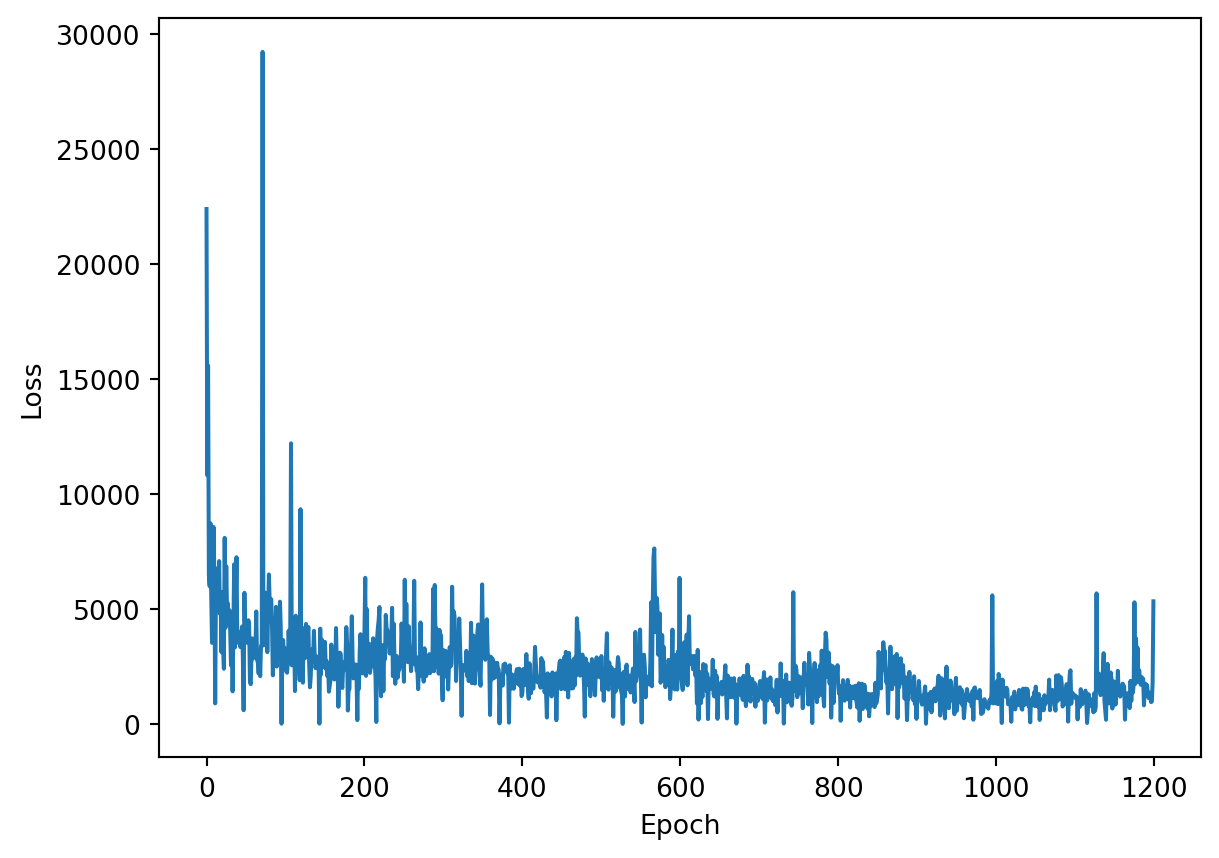

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the Diabetes dataset from sklearn
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a PyTorch dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a PyTorch dataloader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

torch_net.to(getDevice("cpu"))

# train the net
criterion = nn.MSELoss()
optimizer = optim.Adam(torch_net.parameters(), lr=0.01)
n_epochs = 100
losses = []
for epoch in range(n_epochs):
    for inputs, targets in train_dataloader:
        targets = targets.view(-1, 1)
        optimizer.zero_grad()
        outputs = torch_net(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
# visualize the network training
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()